In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import json
import requests
import pickle
import glob
from datetime import datetime
from ast import literal_eval as make_tuple

from functions.util import get_trade, get_prod

## Setup

In [2]:
sns.set_style("whitegrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# For 2019
countries = ['DE','CH','AL',     'AT',     'BA','BE','BG','BY','CY','CZ','DK','EE','ES','FI','FR','GE','GR','HR','HU','IE','IT','LT','LU','LV','MD','ME','MK','MT','NIE','NL','NO','PL','PT','RO','RS','RU','SE','SI','SK','TR','UA','UK','XK']
# Countries we want to import, for 2021
countries = ['DE','CH','AL','AM','AT','AZ','BA','BE','BG','BY','CY','CZ','DK','EE','ES','FI','FR','GE','GR','HR','HU','IE','IT','LT','LU','LV','MD','ME','MK','MT','NIE','NL','NO','PL','PT','RO','RS','RU','SE','SI','SK','TR','UA','UK','XK']


## Scraping the data
Please don't run this part if you already have saved the time series you need. This is bandwidth-consuming (mostly for the server side). The data is publicly available from https://energy-charts.info, which is an amazing visualisation website, not a data repository.

In [5]:
year = '2022'

if  f'.\\prod_and_trade_data_{year}.pickle' in glob.glob('./*'):
    
    f = open('prod_and_trade_data.pickle', 'rb')
    data = pickle.load(f)
    
else:
    
    # Data grab
    data = dict()
    

    for country in countries:
        country = country.lower()

        print(country)
        prod_df, _, _ = get_prod(country=country, # country code
                                        step='hour',
                                 year=year,  # year
                                 display=False, # display chart (or just save data)
                                 load=True,    # show load
                                 cumul=False,  # cumulative
                                 rolling=1,   # rolling average, in timesteps
                                 lang='en')    # language
        print('...production OK')

        trade_df, _ = get_trade(year=year,
                                country=country,
                                lang='en',
                                display=False)
        print('...trade OK')

        data[country] = {'production mix': prod_df,
                         'trade': trade_df}

    f = open(f'.\\prod_and_trade_data_{year}.pickle', 'wb')
    pickle.dump(data , f)

de
https://energy-charts.info/charts/power/data/de/year_2022.json
...production OK
https://energy-charts.info/charts/power/data/de/year_cbpf_saldo_2022.json
...trade OK
ch
https://energy-charts.info/charts/power/data/ch/year_2022.json
...production OK
https://energy-charts.info/charts/power/data/ch/year_cbpf_saldo_2022.json
...trade OK
al
https://energy-charts.info/charts/power/data/al/year_2022.json
...production OK
https://energy-charts.info/charts/power/data/al/year_cbpf_saldo_2022.json
...trade OK
am
https://energy-charts.info/charts/power/data/am/year_2022.json
'Load'
...production OK
https://energy-charts.info/charts/power/data/am/year_cbpf_saldo_2022.json
...trade OK
at
https://energy-charts.info/charts/power/data/at/year_2022.json
...production OK
https://energy-charts.info/charts/power/data/at/year_cbpf_saldo_2022.json
...trade OK
az
https://energy-charts.info/charts/power/data/az/year_2022.json
'Load'
...production OK
https://energy-charts.info/charts/power/data/az/year_cbpf_

In [205]:
_, _, colors = get_prod(country='de', # country code
                                step='hour',
                         year=year,  # year
                         display=False, # display chart (or just save data)
                         load=True,    # show load
                         cumul=False,  # cumulative
                         rolling=1,   # rolling average, in timesteps
                         lang='en')    # language

https://energy-charts.info/charts/power/data/de/year_2022.json


## Making sense of the collected data
It would be too nice if all data were harmonised, of course it is not. Let's first collect the full list of technologies and trade partners.

In [6]:
techs = []
partners = []

for country, datasets in data.items():
    try:
        techs.extend(datasets['production mix'].columns)
        partners.extend(datasets['trade'].columns)
    except:
        pass

In [7]:
# This is only to get the country codes, we don't use the rest of the file
gen_units_per_country = pd.read_csv('generation_units_by_country_2019.csv', index_col=1)['short']

In [8]:
country_codes = {p: gen_units_per_country.loc[p] for p in set(partners) if p in gen_units_per_country.index}

In [10]:
# What are we missing?
set(partners) ^ country_codes.keys()

{'Armenia',
 'Azerbaijan',
 'Ireland',
 'Malta',
 'North Macedonia',
 'Serbia',
 'Slovakia',
 'sum'}

In [11]:
# Add the remaining countries by hand... this will also exclude "sum" from the trade data
country_codes = {**country_codes, **{
                                     'Armenia':'AM',
                                     'Azerbaijan':'AZ',
                                     'Ireland':'IE',
                                     'Malta':'MT',
                                     'North Macedonia':'MK',
                                     'Serbia':'RS',
                                     'Slovakia':'SK'}}

The list of techs is not unique, muhaha.

In [12]:
techs_agg = {'Hydro pumped storage consumption': 'Hydro pumped storage consumption',
               'Import Balance': 'Import balance',
               'Biomass': 'Biomass',
               'Fossil gas': 'Fossil gas',
               'Fossil oil': 'Fossil oil',
               'Fossil oil shale': 'Fossil oil shale',
               'Fossil peat': 'Fossil peat',
               'Hydro pumped storage': 'Hydro pumped storage generation',
               'Hydro Pumped Storage': 'Hydro pumped storage generation',
               'Hydro Run-of-River': 'Hydro run-of-river',
               'Nuclear': 'Nuclear',
               'Others': 'Others',
               'Solar': 'Solar',
               'Waste': 'Waste',
               'Wind offshore': 'Wind',
               'Wind onshore': 'Wind',
               'Pumped Storage consumption': 'Hydro pumped storage consumption',
               'Hydro Power': 'Hydro',
               'Uranium': 'Nuclear',
               'Brown Coal': 'Brown coal',
               'Other renewables': 'Other renewables',
               'Hard Coal': 'Hard coal',
               'Oil': 'Fossil oil',
               'Gas': 'Fossil gas',
               'Pumped Storage generation': 'Hydro pumped storage generation',
               'Wind': 'Wind',
               'Hydro Pumped Storage consumption': 'Hydro pumped storage consumption',
               'Fossil Brown Coal': 'Brown coal',
               'Fossil brown coal / lignite': 'Brown coal',
               'Fossil Hard Coal': 'Hard coal',
               'Fossil Oil': 'Fossil oil',
               'Fossil Gas': 'Fossil gas',
               'Fossil coal-derived gas': 'Fossil coal-derived gas',
               'Hydro Pumped Storage generation': 'Hydro pumped storage generation',
               'Hydro Water Reservoir': 'Hydro',
               'Hydro water reservoir': 'Hydro',
               'Geothermal': 'Geothermal',
               'Fossil hard coal': 'Hard coal'}

In [219]:
colors_harmonized = dict()

for k,v in colors.items():
    if k not in ['Load', 'Residual load', 'Renewable share of generation', 'Renewable share of load'] and not k.startswith('_'):
        colors_harmonized[techs_agg[k]] = v

In [224]:
colors_harmonized

{'Hydro pumped storage consumption': (0.19607843137254902,
  0.19607843137254902,
  0.5882352941176471),
 'Import balance': (0.49019607843137253,
  0.09803921568627451,
  0.49019607843137253),
 'Nuclear': (1.0, 0.0, 0.0),
 'Hydro run-of-river': (0.0, 0.0, 0.7843137254901961),
 'Biomass': (0.0, 0.5882352941176471, 0.19607843137254902),
 'Brown coal': (0.5882352941176471, 0.49019607843137253, 0.39215686274509803),
 'Hard coal': (0.19607843137254902, 0.19607843137254902, 0.19607843137254902),
 'Fossil oil': (0.49019607843137253, 0.39215686274509803, 0.29411764705882354),
 'Fossil gas': (0.9803921568627451, 0.5882352941176471, 0.29411764705882354),
 'Geothermal': (0.19607843137254902, 0.19607843137254902, 0.5882352941176471),
 'Hydro': (0.6862745098039216, 0.7843137254901961, 1.0),
 'Hydro pumped storage generation': (0.0,
  0.5882352941176471,
  0.8823529411764706),
 'Others': (0.5882352941176471, 0.49019607843137253, 0.6862745098039216),
 'Waste': (0.32941176470588235, 0.1882352941176470

In [13]:
# Now let's check the shape of the various tables we have
for country in data.keys():
    
    for kk,vv in data[country].items():
        
        if vv is not None:
            print(country,kk,vv.shape)

de production mix (35040, 19)
de trade (35040, 12)
ch production mix (8760, 9)
ch trade (35040, 5)
al production mix (32544, 1)
al trade (8760, 4)
am production mix (8196, 1)
am trade (8760, 2)
at production mix (35040, 14)
at trade (35040, 7)
az production mix (8196, 1)
az trade (8760, 2)
ba production mix (8760, 8)
ba trade (8760, 4)
be production mix (8760, 15)
be trade (35040, 6)
bg production mix (8760, 14)
bg trade (8760, 6)
by production mix (8196, 1)
by trade (8760, 3)
cy production mix (7655, 4)
cz production mix (8760, 19)
cz trade (8760, 5)
dk production mix (8760, 11)
dk trade (35040, 5)
ee production mix (8760, 13)
ee trade (8760, 4)
es production mix (8760, 17)
es trade (8760, 3)
fi production mix (8760, 14)
fi trade (8760, 5)
fr production mix (8760, 15)
fr trade (8760, 7)
ge production mix (8760, 7)
ge trade (8760, 5)
gr production mix (8760, 7)
gr trade (8760, 6)
hr production mix (8760, 15)
hr trade (8760, 5)
hu production mix (35040, 17)
hu trade (35040, 8)
ie produc

## Cleaning
The next steps are cleaning steps:

- aggregate technology names into the single set of names we defined,
- match country names with their unique code,
- scale the values, trade is in MWh while production is in GWh (except Germany, God knows why).

In [14]:
data_clean = dict()
agg_dict = {'production mix': techs_agg,
            'trade': country_codes}
scale_dict = {'production mix': 1,
              'trade': 1000}

for country in data.keys():
    
    data_clean[country.upper()] = dict()
    
    for k,v in data[country].items():
        
        if v is not None:
            data_clean[country.upper()][k] = v.groupby(agg_dict[k], axis=1).sum().resample("h").mean() * scale_dict[k]
            
#             if country=='de' and k=='production mix':
#                 data_clean[country.upper()][k] *= 1000
            
#             if country=='de' and k=='trade':
#                 data_clean[country.upper()][k] /= 1000


In [15]:
data_clean

{'DE': {'production mix':                       Biomass  Brown coal  Fossil gas  Fossil oil  Geothermal  \
  2021-12-31 23:00:00  4594.200    3777.850    2986.475       111.7      23.050   
  2022-01-01 00:00:00  4586.575    3761.900    2868.900       111.7      23.325   
  2022-01-01 01:00:00  4591.000    3706.950    2864.975       111.7      23.775   
  2022-01-01 02:00:00  4597.850    3717.000    2888.600       111.7      24.175   
  2022-01-01 03:00:00  4599.875    3751.900    2894.125       111.7      24.225   
  ...                       ...         ...         ...         ...         ...   
  2022-12-31 18:00:00  5020.600    4013.625    2372.825         3.6      21.250   
  2022-12-31 19:00:00  4908.100    3955.550    2321.825         3.6      20.975   
  2022-12-31 20:00:00  4804.350    3960.875    2320.025         3.6      20.625   
  2022-12-31 21:00:00  4749.950    3954.500    2461.450         3.6      20.900   
  2022-12-31 22:00:00  4711.350    4011.075    2458.400        

## Treatment
Now we will actually use the data for our objectives.

In [16]:
# Lots of concatenation to obtain a single dataframe containing all the data we want
P = pd.concat([pd.concat({country: pd.concat(data_clean[country], axis=1)}, axis=1, names=['country','type','source']) for country in data_clean.keys()], axis=1)

In [18]:
P

country                         DE                                   \
type                production mix                                    
source                     Biomass Brown coal Fossil gas Fossil oil   
2021-12-31 20:00:00            NaN        NaN        NaN        NaN   
2021-12-31 21:00:00            NaN        NaN        NaN        NaN   
2021-12-31 22:00:00            NaN        NaN        NaN        NaN   
2021-12-31 23:00:00       4594.200   3777.850   2986.475      111.7   
2022-01-01 00:00:00       4586.575   3761.900   2868.900      111.7   
...                            ...        ...        ...        ...   
2022-12-31 19:00:00       4908.100   3955.550   2321.825        3.6   
2022-12-31 20:00:00       4804.350   3960.875   2320.025        3.6   
2022-12-31 21:00:00       4749.950   3954.500   2461.450        3.6   
2022-12-31 22:00:00       4711.350   4011.075   2458.400        3.6   
2022-12-31 23:00:00            NaN        NaN        NaN        NaN   

country                                           \
type                                               
source              Geothermal Hard coal   Hydro   
2021-12-31 20:00:00        NaN       NaN     NaN   
2021-12-31 21:00:00        NaN       NaN     NaN   
2021-12-31 22:00:00        NaN       NaN     NaN   
2021-12-31 23:00:00     23.050  1817.500  40.650   
2022-01-01 00:00:00     23.325  1827.200  98.550   
...                        ...       ...     ...   
2022-12-31 19:00:00     20.975  1936.200  48.325   
2022-12-31 20:00:00     20.625  1954.500  18.200   
2022-12-31 21:00:00     20.900  1953.775  25.125   
2022-12-31 22:00:00     21.000  1941.100  37.900   
2022-12-31 23:00:00        NaN       NaN     NaN   

country                                               \
type                                                   
source              Hydro pumped storage consumption   
2021-12-31 20:00:00                              NaN   
2021-12-31 21:00:00                              NaN   
2021-12-31 22:00:00                              NaN   
2021-12-31 23:00:00                        -1580.575   
2022-01-01 00:00:00                        -1784.125   
...                                              ...   
2022-12-31 19:00:00                        -1184.600   
2022-12-31 20:00:00                        -1981.275   
2022-12-31 21:00:00                        -2217.700   
2022-12-31 22:00:00                        -2239.100   
2022-12-31 23:00:00                              NaN   

country                                                                 ...  \
type                                                                    ...   
source              Hydro pumped storage generation Hydro run-of-river  ...   
2021-12-31 20:00:00                             NaN                NaN  ...   
2021-12-31 21:00:00                             NaN                NaN  ...   
2021-12-31 22:00:00                             NaN                NaN  ...   
2021-12-31 23:00:00                         281.075           1909.600  ...   
2022-01-01 00:00:00                         310.625           1901.775  ...   
...                                             ...                ...  ...   
2022-12-31 19:00:00                         347.425           1642.850  ...   
2022-12-31 20:00:00                         365.800           1634.600  ...   
2022-12-31 21:00:00                         278.675           1627.500  ...   
2022-12-31 22:00:00                         204.850           1618.925  ...   
2022-12-31 23:00:00                             NaN                NaN  ...   

country                     UK                      XK                     \
type                     trade          production mix                      
source                      NL       NO     Brown coal Hydro run-of-river   
2021-12-31 20:00:00        NaN      NaN            NaN                NaN   
2021-12-31 21:00:00        NaN      NaN            NaN                NaN   

### Test for one specific hour of the year

In [26]:
# For the production-consumption adjustment, we have to pick a given hour in the year.
hour=4000

T = P.iloc[hour].unstack('country').fillna(0)
time=P.index[hour]

<AxesSubplot:xlabel='country', ylabel='type-source'>

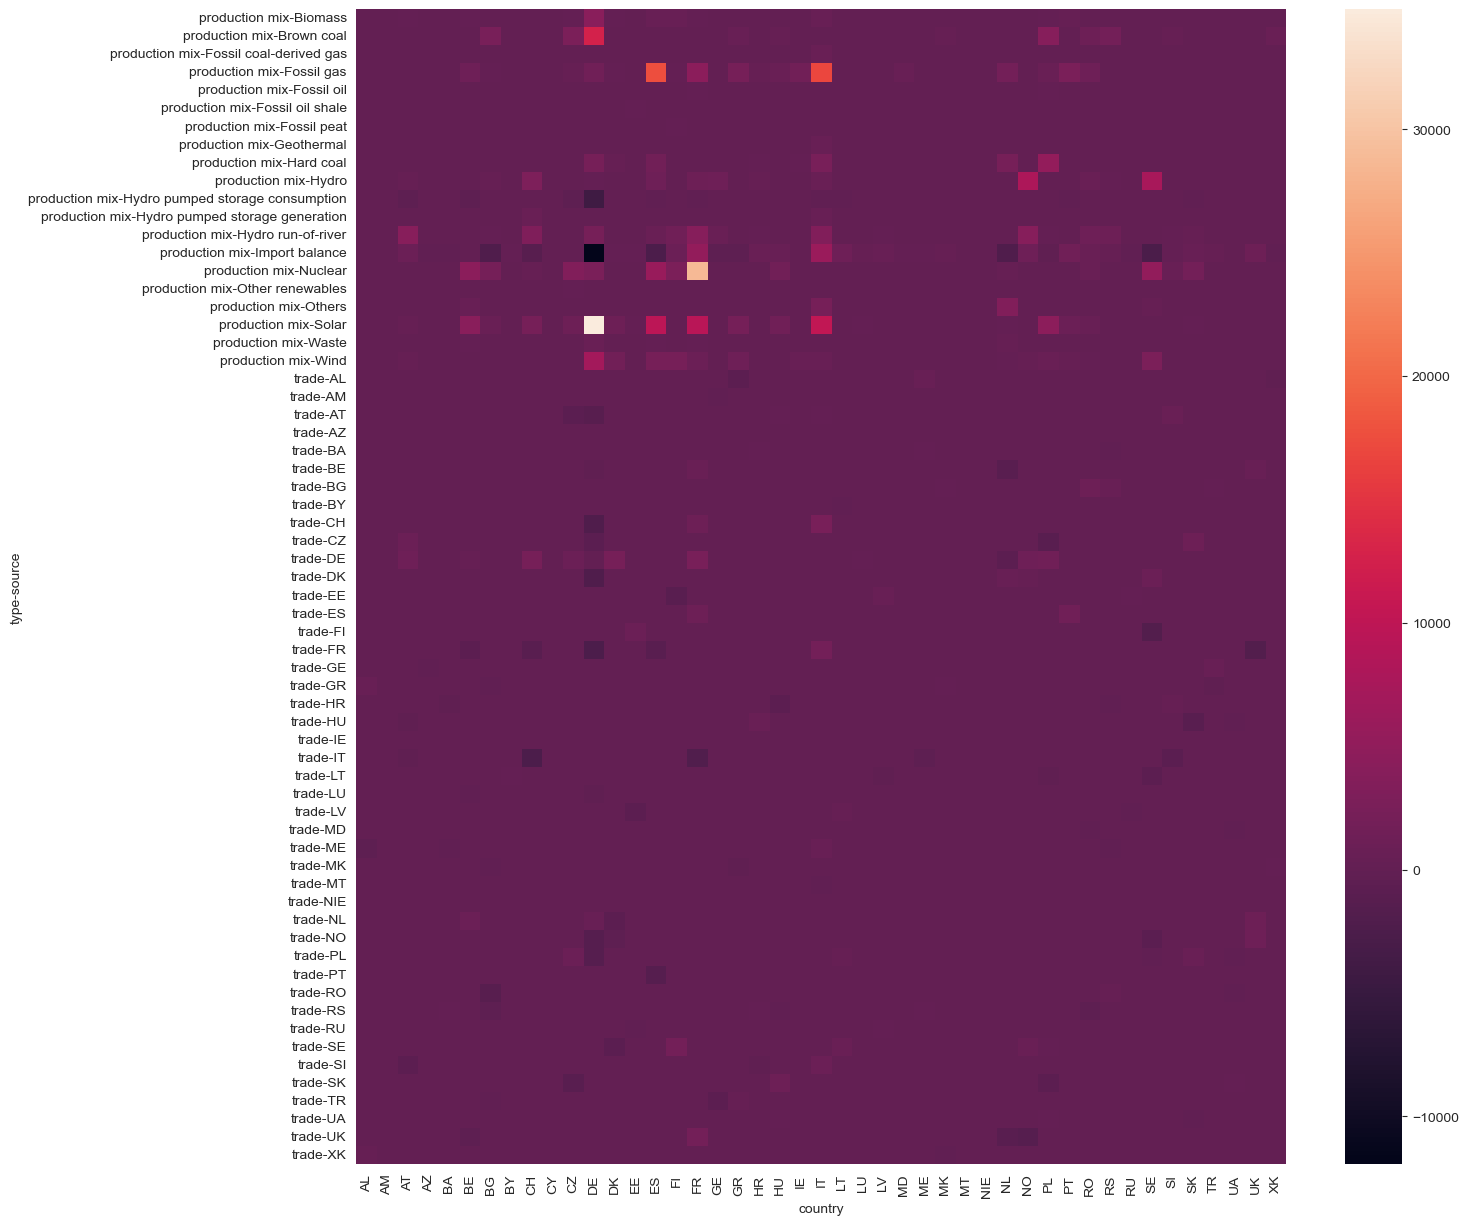

In [20]:
# So what happened on that hour? Let's make a heatmap
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(T, ax=ax)

In [39]:
# Check that trade matches import balance, there will be "border effects" for non-EU countries...
pd.concat([T.loc['trade'].sum(), T.loc[('production mix', 'Import balance')]], axis=1)

,0,"(production mix, Import balance)"
country,,
AL,485.2100,121.300
AM,94.7600,94.800
AT,922.3200,922.300
AZ,-119.4000,-119.400
BA,-178.0000,-178.000
BE,-12.5100,-16.800
BG,-2123.2200,-2123.200
BY,142.0000,142.000
CH,-1291.0850,-1292.900


In [93]:
# Drop import balance as it's already accounted for in the trade matrix
T.drop(('production mix', 'Import balance'), inplace=True)

In [94]:
# Get the full index of countries, the union set of columns (importers) and indices (exporters)
full_index = T.columns | T.loc['trade'].index

In [95]:
# Make T square again
T_sq = T.reindex(full_index, axis=1)

# Exports are already accounted for as imports (their off-diagonal counterparts)
T_sq.loc['trade'][T_sq.loc['trade'] < 0] = 0

# Now build the P matrix, containing share data
P_prod = (T_sq.loc['production mix']/T_sq.sum()).fillna(0)
P_trade = (T_sq.loc['trade'].reindex(full_index)/T_sq.sum()).fillna(0)

In [96]:
# The almighty matrix inversion
L_trade = pd.DataFrame(np.linalg.inv(np.eye(P_trade.shape[0]) - P_trade),
                       index=P_trade.index,
                       columns=P_trade.columns)

In [100]:
# The consumption mix equals the production mixes multiplied by the "full cycle"/resolved graph network
M = P_prod.dot(L_trade)

In [101]:
L_trade['FR'].sort_values(ascending=False)

FR     1.000000e+00
DE     5.045919e-02
UK     3.338520e-02
CH     1.914346e-02
BE     1.893123e-02
ES     1.853387e-02
NO     1.560441e-02
NL     1.427427e-02
DK     1.491983e-03
SE     8.479513e-04
AT     3.007433e-05
CZ     3.536915e-06
PL     3.691049e-07
SK     4.380886e-09
UA     4.380886e-09
PT     0.000000e+00
MT     0.000000e+00
NIE    0.000000e+00
AL     0.000000e+00
RO     0.000000e+00
RS     0.000000e+00
RU     0.000000e+00
ME     0.000000e+00
SI     0.000000e+00
TR     0.000000e+00
MK     0.000000e+00
IT     0.000000e+00
MD     0.000000e+00
LV     0.000000e+00
AZ     0.000000e+00
BA     0.000000e+00
BG     0.000000e+00
BY     0.000000e+00
CY     0.000000e+00
EE     0.000000e+00
FI     0.000000e+00
GE     0.000000e+00
GR     0.000000e+00
HR     0.000000e+00
HU     0.000000e+00
IE     0.000000e+00
AM     0.000000e+00
LT     0.000000e+00
LU     0.000000e+00
XK     0.000000e+00
Name: FR, dtype: float64

In [102]:
pd.concat([P_prod,P_trade],axis=0)

,AL,AM,AT,AZ,BA,BE,BG,BY,CH,CY,...,RO,RS,RU,SE,SI,SK,TR,UA,UK,XK
Biomass,0.000000,0.0,0.037602,0.0,0.0,0.023640,0.004521,0.0,0.0,0.0,...,0.008374,0.006864,0.0,0.0,0.002887,0.021528,0.0,0.0,0.0,0.000000
Brown coal,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.383820,0.0,0.0,0.0,...,0.161778,0.425328,0.0,0.0,0.182730,0.014937,0.0,0.0,0.0,0.783787
Fossil coal-derived gas,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Fossil gas,0.000000,0.0,0.000054,0.0,0.0,0.104566,0.035040,0.0,0.0,0.0,...,0.165262,0.022879,0.0,0.0,0.007236,0.018724,0.0,0.0,0.0,0.000000
Fossil oil,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.011149,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000
TR,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
UA,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.009914,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
UK,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [105]:
comparison = pd.concat([P_prod, M], axis=1, keys=['production','consumption']).sort_index(axis=1, level=1).swaplevel(axis=1)

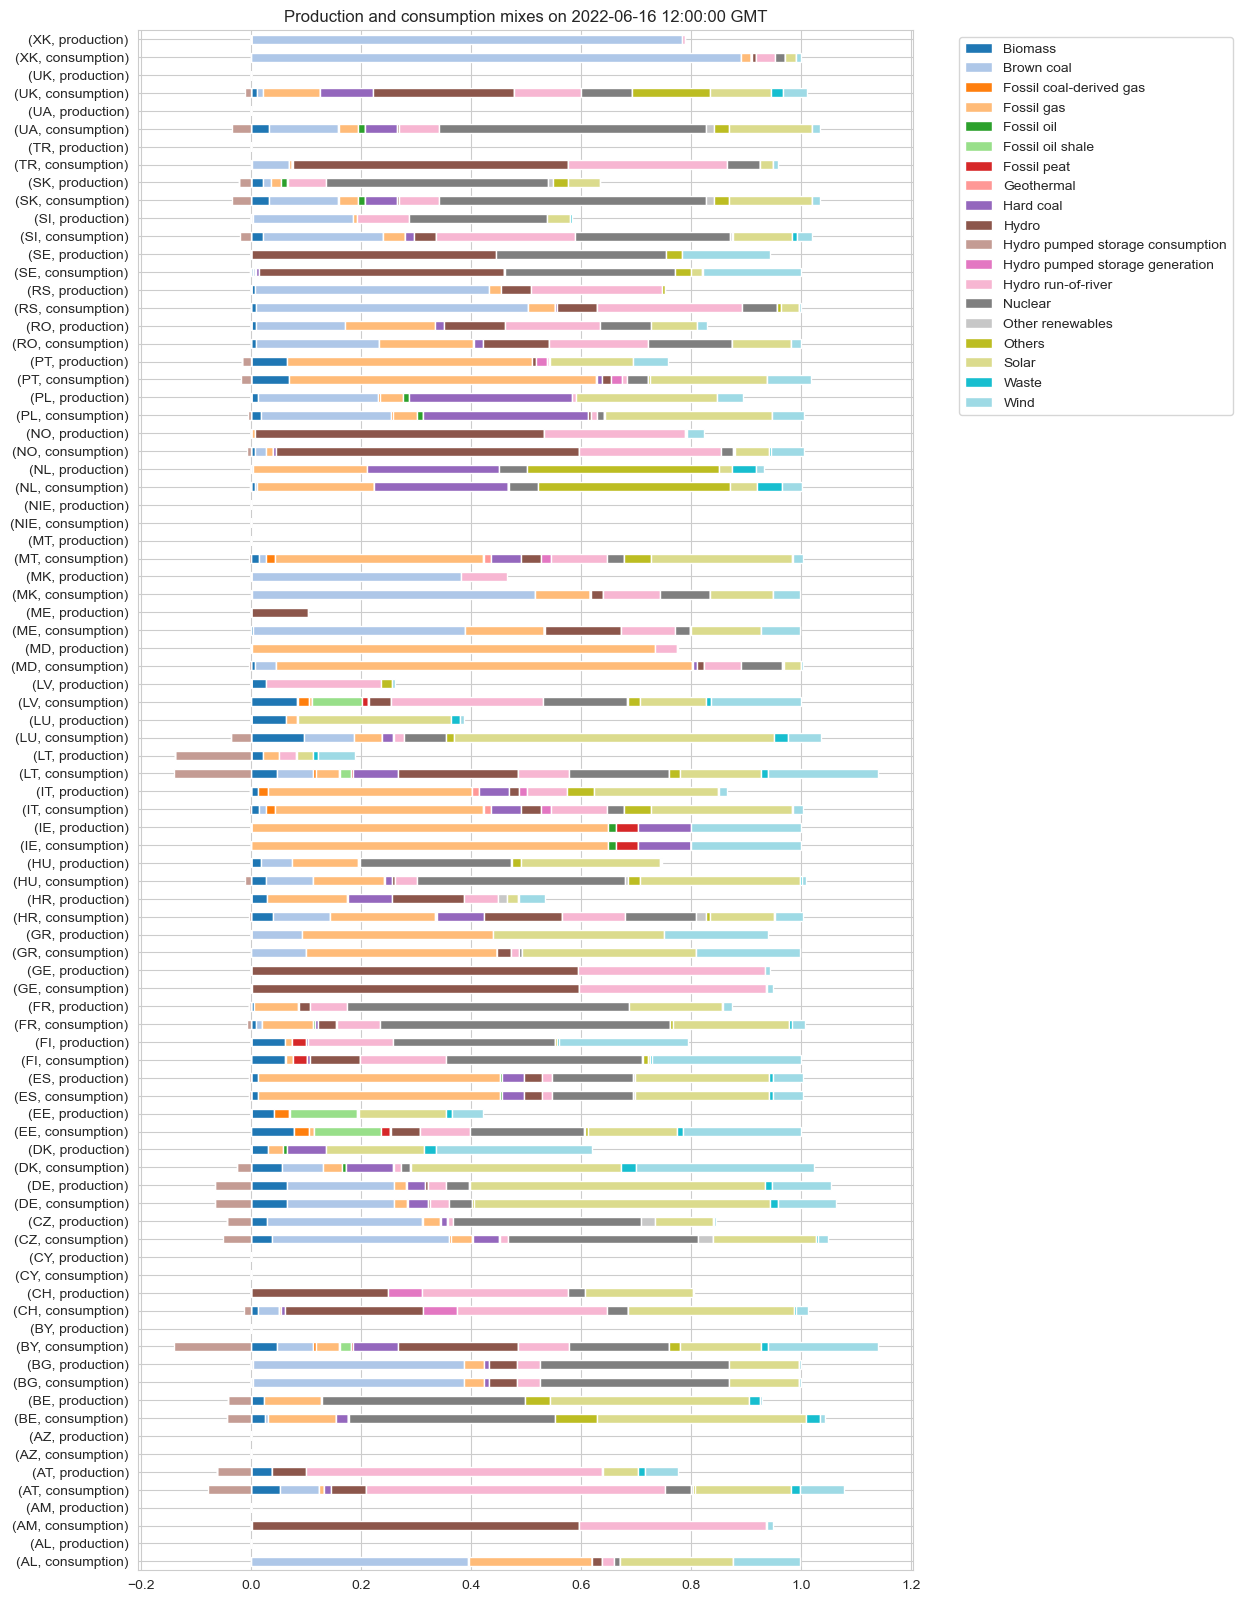

In [106]:
# Let's plot the comparison (some countries will yield strange values, namely RU and BA, probably scale, TO CHECK)
comparison.drop(['RU','BA'],axis=1).T.plot.barh(stacked=True,
                                                figsize=(10,20),
                                                title=f'Production and consumption mixes on {time} GMT',
                                                cmap='tab20')
plt.legend(bbox_to_anchor =(1.05, 1))

### Full year

In [107]:
n_r = full_index.shape[0] # number of regions

In [108]:
T_full = P.stack('country').fillna(0)
T_full.drop(('production mix','Import balance'), axis=1, inplace=True)
T_full['trade'][T_full['trade']<0]=0
P_full = (T_full.div(T_full.sum(1),axis=0)).fillna(0)

In [109]:
time_series =  T_full.index.levels[0].tolist()

In [110]:
P_full.index.names=['datetime', 'country']

In [111]:
full_columns = pd.MultiIndex.from_product([['production mix'],P_full['production mix'].columns]).union(pd.MultiIndex.from_product([['trade'],full_index]))

In [112]:
P_full = P_full.reindex(pd.MultiIndex.from_product([time_series, full_index])).reindex(full_columns, axis=1).fillna(0)

In [113]:
p3d_prod = P_full['production mix'].to_numpy().reshape(8764, n_r, 19)

In [115]:
# quick check, all values have to be within 1% in absolute (seems we can't get a closer match)
np.testing.assert_allclose(p3d_prod[4000,:,:], P_prod.T)

In [119]:
p3d_trade = P_full['trade'].to_numpy().reshape(8764, n_r, n_r).transpose((0,2,1))

In [120]:
np.testing.assert_allclose(p3d_trade[4000,:,:],P_trade)

In [121]:
# quick check
assert all(p3d_trade[4000,:,:] == P_trade.T)

In [125]:
i3d = np.stack([np.eye(p3d_trade.shape[1])]*8764,2).transpose((2,0,1))

In [126]:
l3d = np.linalg.inv(i3d-p3d_trade)

In [128]:
np.testing.assert_allclose(l3d[4000,:,:], L_trade)

In [129]:
# t - time
# c - country of consumption
# s - source (technology)
# i - country of import
mix = np.einsum('tcs,tic->tcs', p3d_prod, l3d)

In [138]:
L_trade.columns.get_loc('FR')

16

In [163]:
pd.DataFrame(l3d[:,:,16], index=time_series, columns=L_trade.columns).drop('FR',axis=1).resample("M").sum()

,AL,AM,AT,AZ,BA,BE,BG,BY,CH,CY,...,RO,RS,RU,SE,SI,SK,TR,UA,UK,XK
2021-12-31,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
2022-01-31,6.930082e-04,5.130503e-06,0.204224,2.495788e-05,4.471947e-03,20.967524,6.512749e-04,0.000076,3.138431,0.0,...,0.000223,0.001649,1.030430e-04,0.170586,1.912905e-02,0.000742,3.894655e-04,0.000359,5.829433,6.144714e-04
2022-02-28,0.000000e+00,0.000000e+00,0.041739,0.000000e+00,0.000000e+00,16.481386,0.000000e+00,0.000006,0.456115,0.0,...,0.000001,0.000000,1.558572e-05,0.111051,0.000000e+00,0.000018,0.000000e+00,0.000007,4.000953,0.000000e+00
2022-03-31,1.652676e-04,1.550406e-06,0.275867,2.813826e-08,4.652978e-04,20.480078,2.090290e-04,0.000136,2.524582,0.0,...,0.000244,0.000596,1.586303e-04,0.339876,2.226166e-03,0.001089,9.303863e-05,0.000455,5.726372,3.693946e-04
2022-04-30,1.427232e-03,1.760675e-05,0.371220,4.398859e-07,6.001290e-03,15.318207,1.639735e-03,0.000163,4.311287,0.0,...,0.000750,0.003578,2.989416e-04,0.304308,2.677802e-02,0.002075,7.619291e-04,0.000969,13.881157,2.605787e-03
2022-05-31,4.681470e-07,0.000000e+00,0.046276,7.717597e-12,1.742421e-07,12.577106,4.260554e-07,0.000008,2.546964,0.0,...,0.000016,0.000001,1.372757e-05,0.211526,6.750437e-07,0.000080,9.781518e-08,0.000096,25.039077,2.972861e-07
2022-06-30,8.268960e-06,0.000000e+00,0.113758,1.749814e-09,4.653357e-06,16.899247,1.340754e-05,0.000013,4.421669,0.0,...,0.000109,0.000029,1.997322e-05,0.166192,6.182649e-05,0.000338,4.721635e-08,0.000308,33.230660,8.128959e-06
2022-07-31,1.481774e-04,0.000000e+00,0.625531,3.154084e-06,1.122428e-04,20.401983,1.175872e-04,0.000043,11.377844,0.0,...,0.000815,0.000147,4.185175e-05,1.079138,2.104876e-03,0.002423,1.714930e-05,0.001602,36.475817,1.288629e-04
2022-08-31,2.599162e-03,0.000000e+00,0.696894,1.323432e-05,9.355203e-04,18.960403,2.269244e-04,0.000029,12.636451,0.0,...,0.000654,0.000646,4.546636e-05,0.329423,1.531538e-02,0.002068,7.396997e-05,0.001378,25.480244,1.591352e-03
2022-09-30,4.184714e-05,0.000000e+00,0.167527,5.775332e-06,4.836377e-05,22.158641,7.177655e-05,0.000008,7.385320,0.0,...,0.000100,0.000070,1.421148e-05,0.285212,1.313316e-03,0.000152,2.715987e-05,0.000194,33.702113,1.027182e-04


In [131]:
mix.shape

(8764, 45, 19)

In [184]:
np.einsum('sc,ic->sc',P_prod,L_trade.T)

array([[ 0.00000000e+00,  4.63600206e-02,  0.00000000e+00,
         3.65715530e-02,  6.31978643e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.59262092e-02,
         1.89312795e-01,  2.33704644e-03,  5.07878838e-02,
         1.57385229e-02,  1.48833345e-01,  1.33498456e-02,
         0.00000000e+00,  0.00000000e+00,  2.24213107e-02,
         2.68753392e-02,  0.00000000e+00,  1.68225675e-02,
         4.21192516e-02,  0.00000000e+00,  7.29448675e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.02065086e-03,  7.10046741e-02,
         5.92269300e-03,  6.90456562e-03,  0.00000000e+00,
         0.00000000e+00,  2.57388720e-03,  2.77369148e-02,
         0.00000000e+00,  0.00000000e+00,  6.06377187e-02,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  3.39504511e-01,
         0.00000000e+00,  2.11712845e-01,  0.00000000e+00,
         0.00000000e+00,  0.00

<AxesSubplot:>

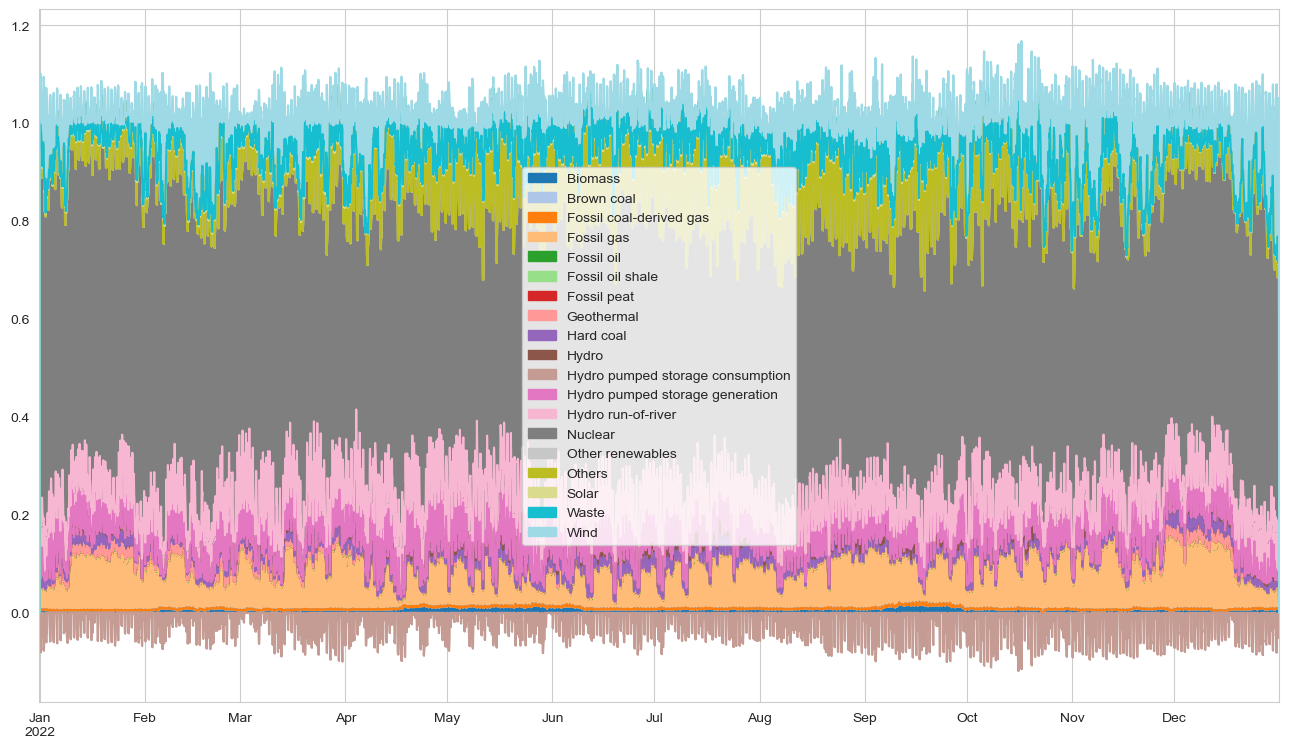

In [223]:
fig, ax = plt.subplots(figsize=(16,9))
pd.DataFrame(mix[:,16,:],
             index=time_series,
             columns=P_full['production mix'].columns).plot.area(stacked=True, cmap='tab20', ax=ax)

<AxesSubplot:>

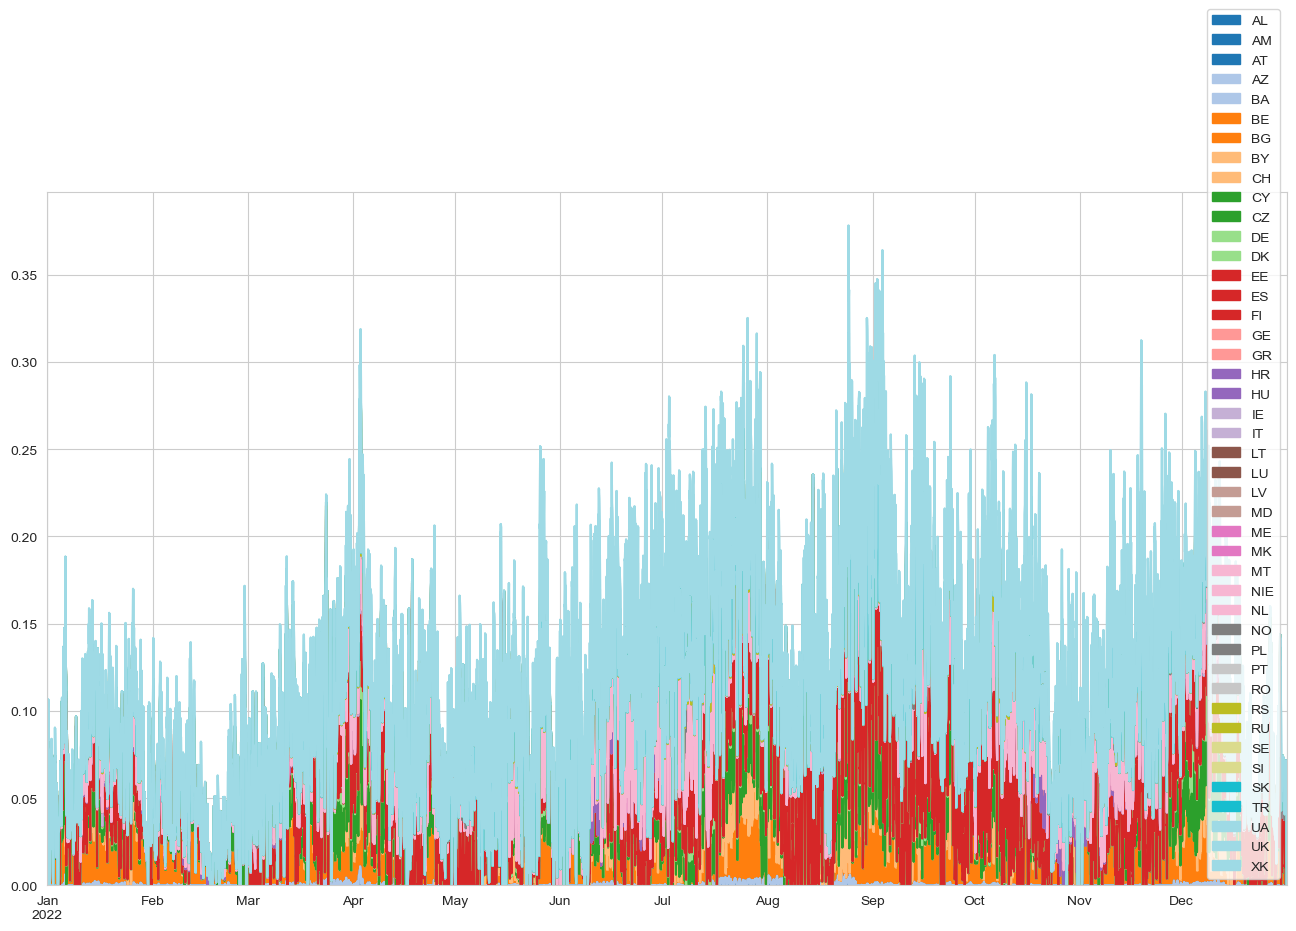

In [181]:
fig, ax = plt.subplots(figsize=(16,9))
pd.DataFrame(l3d[:,:,16],
             index=time_series,
             columns=L_trade.columns).drop('FR',axis=1).plot.area(stacked=True, cmap='tab20', ax=ax)

<AxesSubplot:>

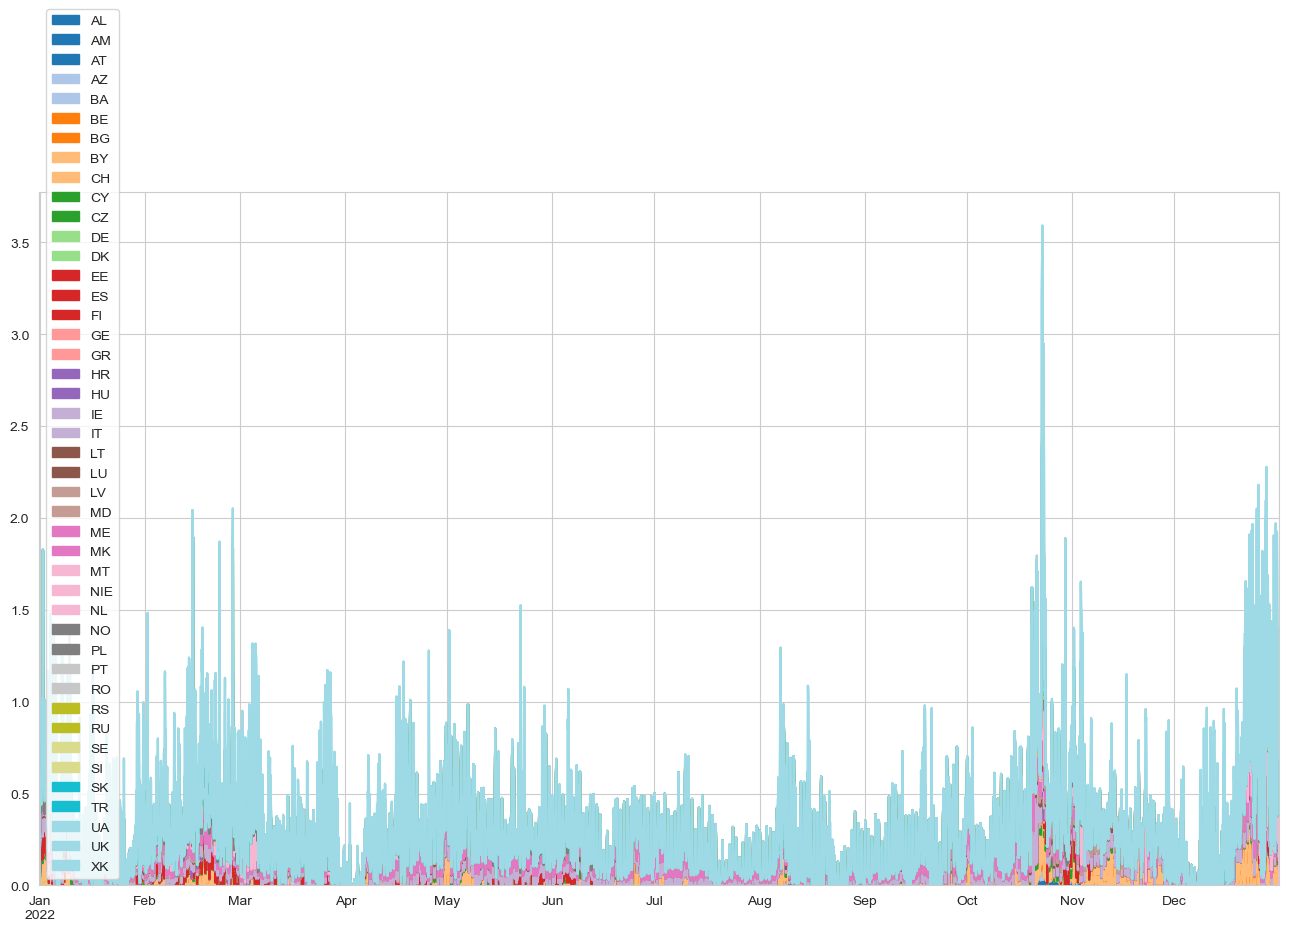

In [196]:
fig, ax = plt.subplots(figsize=(16,9))
pd.DataFrame(l3d[:,16,:],
             index=time_series,
             columns=L_trade.columns).drop('FR',axis=1).plot.area(stacked=True, cmap='tab20', ax=ax)

In [190]:
pd.DataFrame(l3d[:,:,16],
             index=time_series,
             columns=L_trade.columns).drop('FR',axis=1).sum()

AL       0.009748
AM       0.000042
AT       2.811895
AZ       0.000197
BA       0.016532
BE     222.305060
BG       0.003557
BY       0.000520
CH      57.181129
CY       0.000000
CZ       2.195548
DE     173.056699
DK       5.888250
EE       0.001262
ES     245.572800
FI       0.009508
GE       0.001133
GR       0.041390
HR       0.035944
HU       0.045050
IE       9.817852
IT       5.028747
LT       0.004486
LU       0.274456
LV       0.001207
MD       0.004853
ME       0.052388
MK       0.001577
MT       0.000254
NIE     15.309035
NL      61.881343
NO      70.039486
PL       0.279839
PT       1.945698
RO       0.003986
RS       0.009377
RU       0.000786
SE       4.166911
SI       0.110499
SK       0.016069
TR       0.001958
UA       0.006707
UK     248.361769
XK       0.007566
dtype: float64

## Quick analysis for Luxembourg balance

In [185]:
regions = ['BE','DE','FR','LU']

In [186]:
trade_LU = dict()

for region in regions:
    
    trade_LU[region] = pd.concat([data_clean[region]['trade'][data_clean[region]['trade']<0].sum(),
                                  data_clean[region]['trade'][data_clean[region]['trade']>0].sum()],
                                 keys=['exports','imports'],
                                axis=1)
    
    
trade_LU_df = pd.concat(trade_LU, axis=1)/1000

In [187]:
trade_LU_df

BE                        DE                        FR  \
        exports      imports      exports      imports      exports   
DE     0.000000     0.000000          NaN          NaN -14827.35843   
FR -3228.619700  6012.985060  -1717.56874  14827.35843          NaN   
LU  -183.994300    92.026480  -4033.07253      0.00000          NaN   
NL -4494.845310  5422.111270  -9134.64157   2945.57727          NaN   
UK -5485.405332   125.986935          NaN          NaN -11988.26600   
AT          NaN          NaN -12188.67032    253.43838          NaN   
BE          NaN          NaN      0.00000      0.00000  -6012.98506   
CH          NaN          NaN -11805.59950   3434.86916  -7685.86330   
CZ          NaN          NaN  -5599.30709   1652.42967          NaN   
DK          NaN          NaN  -6108.37190   2658.65007          NaN   
NO          NaN          NaN      0.00000      0.00000          NaN   
PL          NaN          NaN -10070.32496      6.49339          NaN   
SE          NaN          NaN   -564.56337   1306.02686          NaN   
ES          NaN          NaN          NaN          NaN -12254.83504   
IT          NaN          NaN          NaN          NaN -15134.88200   

                      LU              
       imports   exports     imports  
DE  1717.56874   0.00000  4033.07253  
FR         NaN       NaN         NaN  
LU         NaN       NaN         NaN  
NL         NaN       NaN         NaN  
UK   704.29400       NaN         NaN  
AT         NaN       NaN         NaN  
BE  3228.61970 -92.02648   183.99430  
CH  2011.33962       NaN         NaN  
CZ         NaN       NaN         NaN  
DK         NaN       NaN         NaN  
NO         NaN       NaN         NaN  
PL         NaN       NaN         NaN  
SE         NaN       NaN         NaN  
ES  2727.05082       NaN         NaN  
IT    97.60000       NaN         NaN

In [193]:
trade_LU['FR']/1000

,exports,imports
BE,-6012.98506,3228.61970
CH,-7685.86330,2011.33962
DE,-14827.35843,1717.56874
ES,-12254.83504,2727.05082
IT,-15134.88200,97.60000
UK,-11988.26600,704.29400


In [189]:
data_clean['BE']['trade'][data_clean['BE']['trade']>0].sum()/1000

DE       0.000000
FR    6012.985060
LU      92.026480
NL    5422.111270
UK     125.986935
dtype: float64

In [190]:
data_clean['BE']['trade'][data_clean['BE']['trade']<0].sum()/1000

DE       0.000000
FR   -3228.619700
LU    -183.994300
NL   -4494.845310
UK   -5485.405332
dtype: float64

In [54]:
data_clean['DE']['trade'][data_clean['DE']['trade']>0].sum()/1000

AT    1149.679275
BE    1784.224095
CH    1304.405977
CZ    3421.583100
DK    6858.615735
FR    9278.581390
LU       0.000000
NL    4461.870945
NO    4286.165922
PL     128.594690
SE    2220.002895
dtype: float64

In [55]:
data_clean['DE']['trade'][data_clean['DE']['trade']<0].sum()/1000

AT    -8692.741045
BE    -2571.357482
CH   -13866.969188
CZ    -3678.206740
DK    -2990.202153
FR    -3696.611970
LU    -3108.859807
NL    -5906.392843
NO    -1116.666903
PL    -8534.197135
SE     -279.091400
dtype: float64

In [56]:
data_clean['FR']['trade'][data_clean['FR']['trade']>0].sum()/1000

BE    6968.24468
CH    1955.99329
DE    3696.61197
ES    5933.74484
IT     350.61500
UK    1358.89200
dtype: float64

In [57]:
data_clean['FR']['trade'][data_clean['FR']['trade']<0].sum()/1000

BE    -4371.426930
CH    -8217.507070
DE    -9278.581390
ES   -11498.225545
IT   -14976.831000
UK   -14766.381000
dtype: float64